# XPN 90s A to Z Countdown

It's countdown time at [XPN](https://xpn.org).
While I took a year off from doing stats last year,
as the station did a bang up job and I had other things going on,
I'm up for another crack at it.

This year it's the [90s A-Z](https://xpn.org/program/90s-a-z/) countdown, 
which stated at 8am on December 1st.
There's a [Real Time Countdown](https://xpn.org/countdown/90s-a-z/)
and the usual [Twitter banter](https://twitter.com/search?q=%23XPN90sAtoZ).



In [1]:
%matplotlib inline
from IPython.display import display, HTML

## Status

It's Tuesday, Dec 6, things have been running for just over five days, and we're up to S.

  - Resurrected most of the [Data Loading](Dataloading2.ipynb) with updates for the new playlist format
  - Started with the the absolute basics
  - Added in the trivial manipulations that don't need much data augmentation
  - Took a pass at doing breakdown by years. It needs work. But running with it for the moment
  - Added scan for sequential tracks by the same artist.
  - Added pivots for artist by year and by letter.

## Loading Data

Most people don't care about how I get the data.
If you do, checkout my [Dataloading](Dataloading2.ipynp) notebook.
If you just want to play with the data,
the playlist with some data augmentation, is here as [90sA2Z.csv](data/90sA2Z.csv).
If you do something interesting, let me know,
and post with the `#XPN90sAtoZ` hashtag so people can find it.

In [2]:
import pandas as pd
from datetime import date, datetime, time, timedelta
from os import path
data_dir = './data'
playlist_file = path.join(data_dir, '90sA2Z.csv')
playlist = pd.read_csv(playlist_file)

playlist['Air Time'] = pd.to_datetime(playlist['Air Time'], errors='coerce')
last_play = playlist.loc[playlist['Air Time'].idxmax()]
end_time = last_play['Air Time'] + timedelta(seconds = 60 * last_play['Duration'])
HTML('<p>So far, as of %s, we have seen %d tracks with %d unique titles, from %d artists.</p>' %\
    (end_time.strftime('%b %d %I:%M%p'),
     len(playlist),
     playlist.describe(include='all')['Title']['unique'], 
     playlist.describe(include='all')['Artist']['unique']
     ))

## Analysis

### Most Popular Artist
The first question everyone seems to ask is "which artist has been played the most".



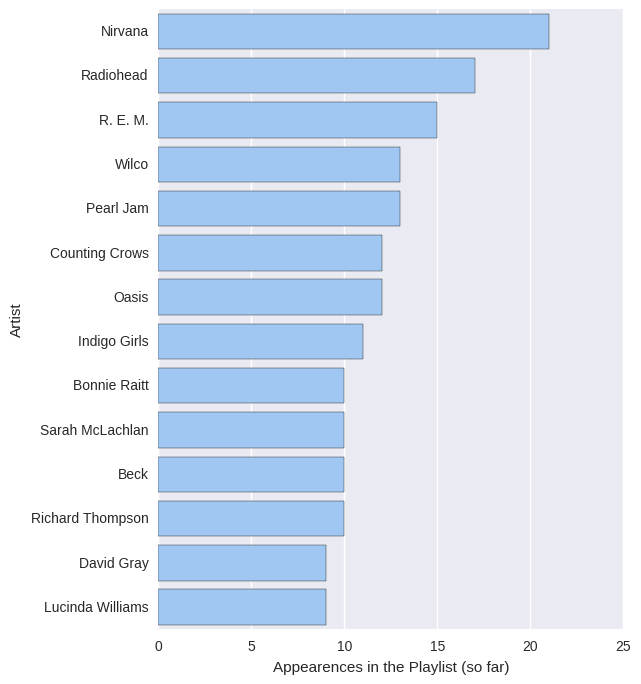

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
c = playlist['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'Count'))
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='Count', data=artists[artists['Count'] > 8], color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

### Popular Albums

I'd always wanted to group on albums. 
But using an external source like [MusicBrainz](https://musicbrainz.org/) 
to find / guess album names based on artist and title was kind of problematic.
Now that album is in the new playlist format, this is easy.


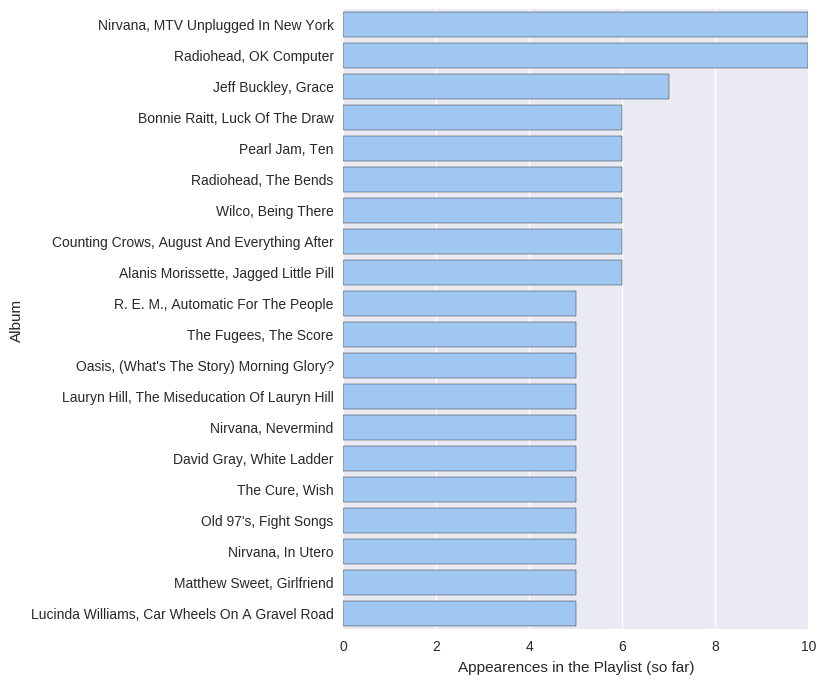

In [4]:
albums = playlist.groupby(['Artist', 'Album']).size().reset_index().rename(columns={0:'Count'})
albums = albums.sort_values(by=['Count'], ascending=False)
albums["label"] = albums['Artist'] + ', ' + albums['Album']
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.barplot(y='label', x='Count', data=albums[albums['Count'] > 4], color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")
ax.set(ylabel="Album")


### Songs By Letter
If we are doing A to Z, it's probably good to know how far we are, 
and have some notion of where we're going.

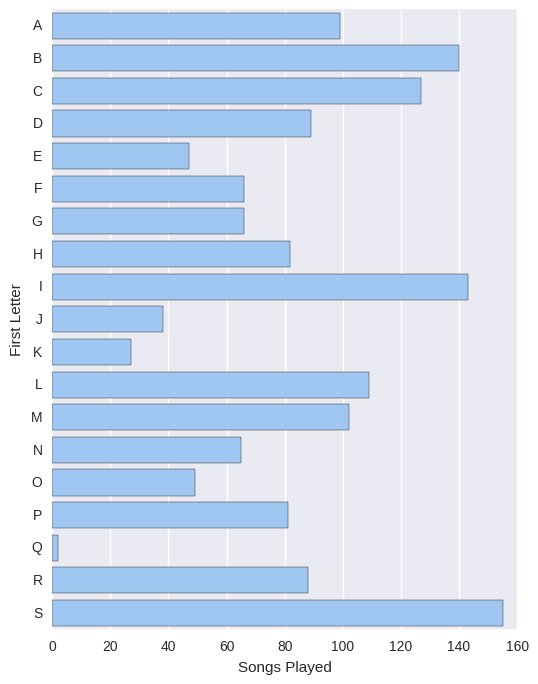

In [5]:
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.countplot(y='Letter', data=playlist, color='b')
ax.set(xlabel="Songs Played", ylabel="First Letter")

# Tracks by Year
Well, years are what a 90s countdown is about.
I've had mixed results in earlier years trying to get release dates 
by looking for matches on [MusicBrainz](https://musicbrainz.org/).
So, right now I'm using the datas from the [90s A-Z playlist page](https://xpn.org/countdown/90s-a-z/).
They may not be a lot better.
We're only batting a bit over 90%
But here's what we got.

In [6]:
print "Of %d tracks, %d had valid dates and %d did not" % \
    (len(playlist), len(playlist[playlist['Year'] > 0]), len(playlist[playlist['Year'] == 0]))

Of 1575 tracks, 1434 had valid dates and 141 did not


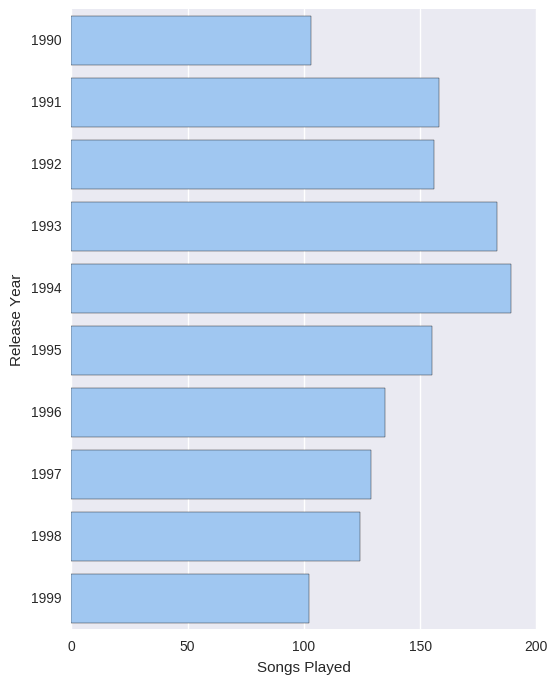

In [7]:
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
sns.countplot(y='Year', data=playlist[playlist['Year'] > 0], color='b')
ax.set(xlabel="Songs Played", ylabel="Release Year")

### Covererage

Has an artist had a track played for each letter yet?  Unlikely, but who comes the closest?
This really relates to number of tracks played and, to some degree, diversity of naming.
Similary, has any artist had a track played for each year?
That's an easier goal, but relies a lot on consistant output.

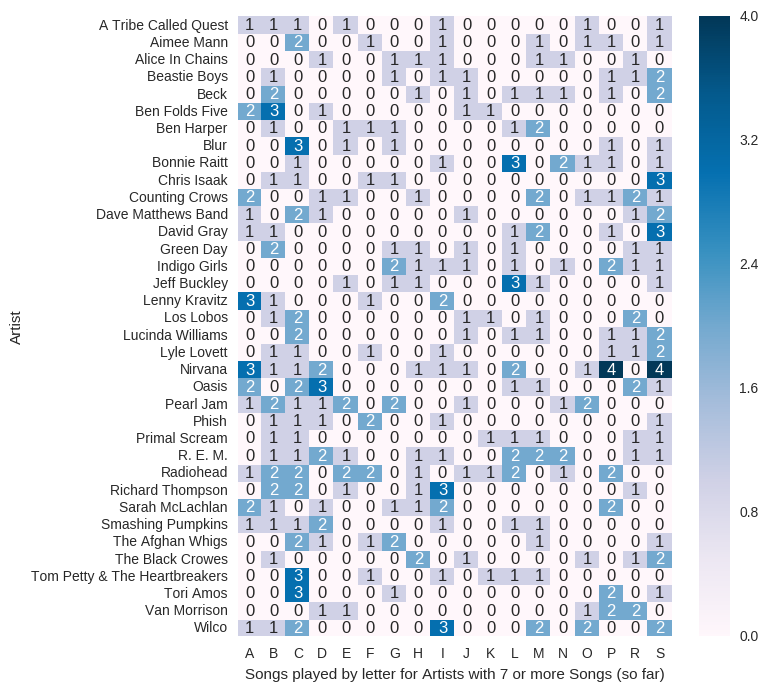

In [8]:
c = playlist[playlist.groupby('Artist')['Artist'].transform('size') >= 7]
c = c.groupby(['Artist', 'Letter']).count()
c.reset_index(level=[0,1], inplace=True)
c = c.pivot('Artist', 'Letter', 'Title').fillna(0)
f, ax = plt.subplots(figsize=(7, 8))
sns.set_color_codes('pastel')
ax = sns.heatmap(c, annot=True, cmap='PuBu')
ax.set(xlabel="Songs played by letter for Artists with 7 or more Songs (so far)")

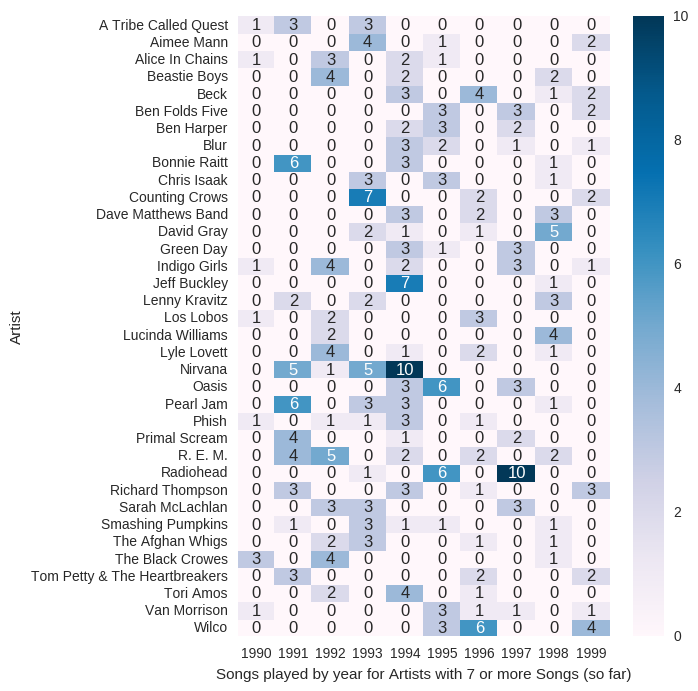

In [9]:
c = playlist[playlist.groupby('Artist')['Artist'].transform('size') >= 7]
c = c[c['Year'] > 0]
c = c.groupby(['Artist', 'Year']).count()
c.reset_index(level=[0,1], inplace=True)
c = c.pivot('Artist', 'Year', 'Title').fillna(0)
f, ax = plt.subplots(figsize=(6, 8))
sns.set_color_codes('pastel')
ax = sns.heatmap(c, annot=True, cmap='PuBu')
ax.set(xlabel="Songs played by year for Artists with 7 or more Songs (so far)")

### Longest Songs
At some level the duration we calculate is somewhat suspect.
There are station id breaks, and such.
So just counting start to start is iffy.
But it's still interesting.

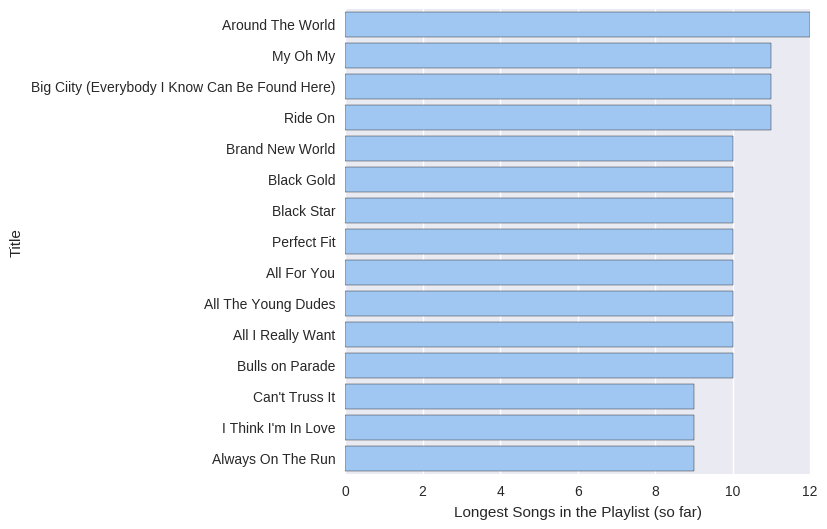

In [10]:
long_songs = playlist.sort_values(by='Duration', ascending=False)
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Title', x='Duration', data=long_songs.head(15), color='b')
ax.set(xlabel="Longest Songs in the Playlist (so far)")

## Sequential Runs by an Artist

How often do we get runs of two or more consecutive tracks by the same artist?
It happens.  The alphabet is a strange thing.

Note, I'm not sure that the same artist playing the same song really counts.
But the two plays of *All Apologies* by Nirvana really happened.
They were from *In Utero* and *MTV Unplugged in New York*.
So a self cover?

In [11]:
def sequential_runs(tracks):
    runs = pd.DataFrame(None, columns = ['Artist', 'Songs'])
    artist = None
    titles = []
    for idx in tracks.index:
        if tracks['Artist'][idx] == artist:
            titles.append(tracks['Title'][idx])
        else:
            if len(titles) > 1:
                runs = runs.append({'Artist': artist,
                                   'Songs': titles},
                                  ignore_index=True)
            artist = tracks['Artist'][idx]
            titles = [tracks['Title'][idx]]
    return runs
        


In [12]:
HTML(sequential_runs(playlist).to_html(index=False))

Artist,Songs
Nirvana,"[All Apologies, All Apologies]"
Gomez,"[Get Miles, Get Myself Arrested]"
Pearl Jam,"[Given to Fly, Glorified G]"
Guided By Voices,"[I Am A Scientist, I Am A Tree]"
The Lemonheads,"[It's A Shame About Ray, It's About Time]"
Ben Harper,"[Mama's Got A Girlfriend, Mama's Trippin']"
Wilco,"[Outta Mind (Outta Sight), Outtasite (Outta Mi..."
Nirvana,"[Pennyroyal Tea, Pennyroyal Tea]"
Los Lobos,"[Reva's House, Revolution]"


### Duplicate Titles
Duplicate titles could be covers. or they could just be "same name, different song".


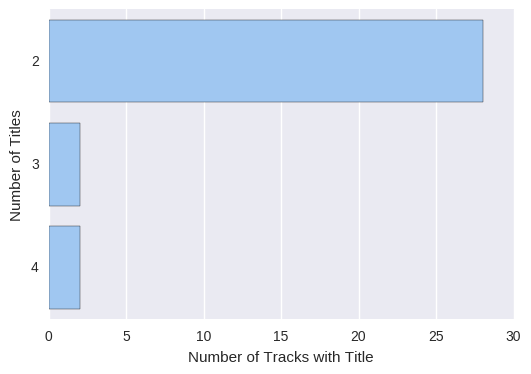

In [13]:
c = playlist['Title'].value_counts()
title_counts = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                           columns=('Title', 'Count'))
f, ax = plt.subplots(figsize=(6, 4))
sns.set_color_codes('pastel')
sns.countplot(y='Count', data=title_counts[title_counts['Count'] > 1], color='b')
ax.set(xlabel="Number of Tracks with Title", ylabel="Number of Titles")


In [14]:
HTML(title_counts[title_counts['Count'] > 1].sort_values(by='Title').to_html(index=False))

Title,Count
All Apologies,3
Alright,2
Be Thankful For What You Got,2
Believe,2
Blue,2
Changes,2
Closing Time,2
Congo Square,2
Crazy,2
Creep,4


## Availability
The code for this project is in [my github repo](https://github.com/asudell/a2z)
and this file is specifically [90sA2Z.ipynb](https://github.com/asudell/a2z/blob/master/90sA2Z.ipynb).

## License


This project is licensed under a
[Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).
You are free to use for commercial or non-commercial purposes,
so long as you attribute the source and also allow sharing.